# Signal Denoising: Kalman Filter vs Exponential Moving Average (EMA)

This notebook demonstrates the **steady-state Kalman filter** for denoising a 1D signal and compares it with a simple **Exponential Moving Average (EMA)**.

**Key takeaway:** Both filters smooth noisy measurements, but the Kalman filter models the underlying dynamics (velocity, acceleration) and therefore has a **faster response** to real signal changes while still suppressing noise effectively.

## System model

We model a 1D signal as a position with velocity (constant-velocity model):

$$x(n+1) = \begin{bmatrix} 1 & dt \\ 0 & 1 \end{bmatrix} x(n)$$

$$y(n) = \begin{bmatrix} 1 & 0 \end{bmatrix} x(n) + \text{noise}$$

The state vector $x = [p, v]^T$ contains position and velocity. We only observe noisy position.

In [1]:
import numpy
import matplotlib.pyplot as plt

import AILibs

rng = numpy.random.default_rng(42)

## 1. Generate a test signal

A signal with smooth segments, step changes, and a ramp — designed to show how each filter responds to sudden transitions.

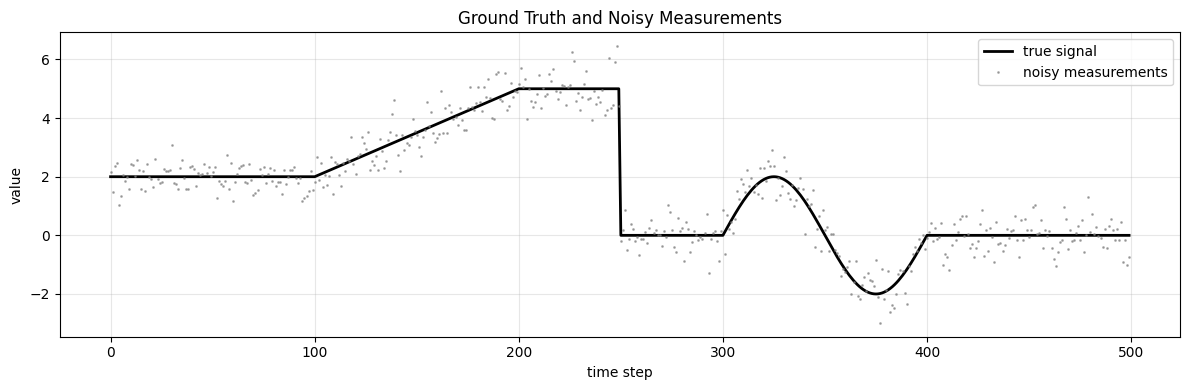

In [2]:
# build a ground-truth signal with interesting features
n_steps = 500
dt = 1.0

# piecewise signal: constant → ramp → step → sine → constant
t = numpy.arange(n_steps) * dt
signal_true = numpy.zeros(n_steps)

signal_true[0:100]   = 2.0                                          # constant
signal_true[100:200] = 2.0 + 3.0 * (t[100:200] - t[100]) / 100.0   # ramp up
signal_true[200:250] = 5.0                                          # constant
signal_true[250:300] = 0.0                                          # step down
signal_true[300:400] = 2.0 * numpy.sin(2.0 * numpy.pi * (t[300:400] - t[300]) / 100.0)  # sine
signal_true[400:500] = 0.0                                          # constant

# add measurement noise
sensor_std = 0.5
noise = rng.normal(0, sensor_std, n_steps)
signal_noisy = signal_true + noise

plt.figure(figsize=(12, 4))
plt.plot(t, signal_true, "k-", linewidth=2, label="true signal")
plt.plot(t, signal_noisy, ".", color="gray", markersize=2, alpha=0.6, label="noisy measurements")
plt.xlabel("time step")
plt.ylabel("value")
plt.title("Ground Truth and Noisy Measurements")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Exponential Moving Average (EMA) baseline

EMA with smoothing factor $\alpha$:

$$\hat{y}(n) = \alpha \cdot y(n) + (1 - \alpha) \cdot \hat{y}(n-1)$$

Small $\alpha$ → more smoothing but **slower response**.  
Large $\alpha$ → faster response but **less noise suppression**.

In [3]:
def ema_filter(signal, alpha):
    """Exponential moving average filter."""
    result = numpy.zeros_like(signal)
    result[0] = signal[0]
    for i in range(1, len(signal)):
        result[i] = alpha * signal[i] + (1.0 - alpha) * result[i - 1]
    return result

# try two EMA settings
ema_fast = ema_filter(signal_noisy, alpha=0.3)   # faster but noisier
ema_slow = ema_filter(signal_noisy, alpha=0.05)  # smoother but laggy

## 3. Kalman filter setup

Constant-velocity model — the filter estimates both **position** and **velocity** from noisy position-only measurements.

In [4]:
# state: [position, velocity]
# constant-velocity model: p(n+1) = p(n) + dt*v(n), v(n+1) = v(n)
A = numpy.array([
    [1.0, dt],
    [0.0, 1.0]
])

# no control input
B = numpy.zeros((2, 1))

# we observe only position
H = numpy.array([[1.0, 0.0]])

# process noise — allows the filter to track signal changes
# tuning: larger q → filter trusts measurements more, responds faster
q_var = 0.01
Q = numpy.array([
    [0.25 * dt**4, 0.5 * dt**3],
    [0.5  * dt**3, 1.0 * dt**2]
]) * q_var

# measurement noise covariance
R = numpy.array([[sensor_std**2]])

kf = AILibs.dsp.KalmanFilter(A, B, H, Q, R)

print(f"Kalman gain K:\n{kf.k}")
print(f"\nK shape: {kf.k.shape}  (n_states × n_outputs)")

Kalman gain K:
[[0.46732804]
 [0.14596876]]

K shape: (2, 1)  (n_states × n_outputs)


## 4. Run the Kalman filter

In [5]:
# run Kalman filter on noisy measurements
u_zero = numpy.zeros((1, 1))  # no control input

kalman_position = numpy.zeros(n_steps)
kalman_velocity = numpy.zeros(n_steps)

for i in range(n_steps):
    y_obs = numpy.array([[signal_noisy[i]]])
    x_est = kf.step(y_obs, u_zero)
    kalman_position[i] = x_est[0, 0]
    kalman_velocity[i] = x_est[1, 0]

## 5. Compare all filters

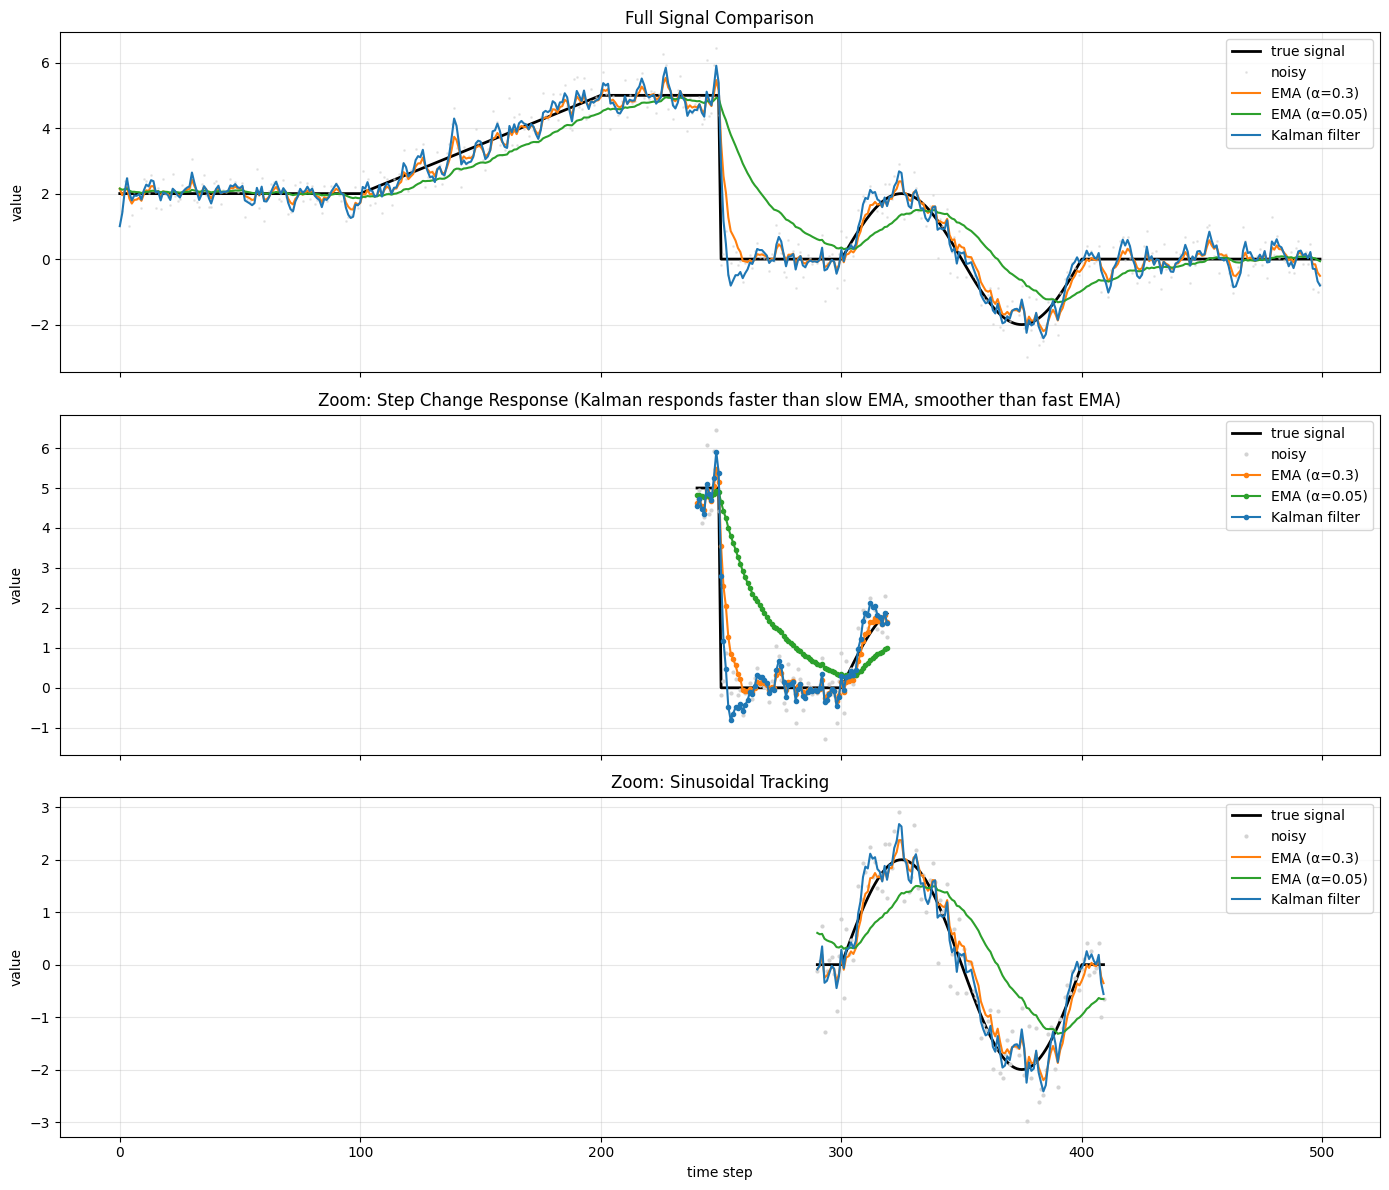

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# --- full signal comparison ---
ax = axes[0]
ax.plot(t, signal_true, "k-", linewidth=2, label="true signal")
ax.plot(t, signal_noisy, ".", color="lightgray", markersize=2, alpha=0.5, label="noisy")
ax.plot(t, ema_fast, "-", linewidth=1.5, label=f"EMA (α=0.3)", color="tab:orange")
ax.plot(t, ema_slow, "-", linewidth=1.5, label=f"EMA (α=0.05)", color="tab:green")
ax.plot(t, kalman_position, "-", linewidth=1.5, label="Kalman filter", color="tab:blue")
ax.set_ylabel("value")
ax.set_title("Full Signal Comparison")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# --- zoom into step change (shows response speed) ---
ax = axes[1]
zoom = slice(240, 320)
ax.plot(t[zoom], signal_true[zoom], "k-", linewidth=2, label="true signal")
ax.plot(t[zoom], signal_noisy[zoom], ".", color="lightgray", markersize=4, label="noisy")
ax.plot(t[zoom], ema_fast[zoom], "-o", linewidth=1.5, markersize=3, label=f"EMA (α=0.3)", color="tab:orange")
ax.plot(t[zoom], ema_slow[zoom], "-o", linewidth=1.5, markersize=3, label=f"EMA (α=0.05)", color="tab:green")
ax.plot(t[zoom], kalman_position[zoom], "-o", linewidth=1.5, markersize=3, label="Kalman filter", color="tab:blue")
ax.set_ylabel("value")
ax.set_title("Zoom: Step Change Response (Kalman responds faster than slow EMA, smoother than fast EMA)")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# --- zoom into sine segment ---
ax = axes[2]
zoom = slice(290, 410)
ax.plot(t[zoom], signal_true[zoom], "k-", linewidth=2, label="true signal")
ax.plot(t[zoom], signal_noisy[zoom], ".", color="lightgray", markersize=4, label="noisy")
ax.plot(t[zoom], ema_fast[zoom], "-", linewidth=1.5, label=f"EMA (α=0.3)", color="tab:orange")
ax.plot(t[zoom], ema_slow[zoom], "-", linewidth=1.5, label=f"EMA (α=0.05)", color="tab:green")
ax.plot(t[zoom], kalman_position[zoom], "-", linewidth=1.5, label="Kalman filter", color="tab:blue")
ax.set_ylabel("value")
ax.set_xlabel("time step")
ax.set_title("Zoom: Sinusoidal Tracking")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Quantitative comparison

Compute MSE and MAE for each filter against the true signal (excluding initial transient).

In [7]:
# skip initial transient (first 20 samples)
k = 20

def compute_errors(estimate, true_signal, start=k):
    err = estimate[start:] - true_signal[start:]
    mse = numpy.mean(err**2)
    mae = numpy.mean(numpy.abs(err))
    return mse, mae

mse_noisy, mae_noisy   = compute_errors(signal_noisy, signal_true)
mse_ema_f, mae_ema_f   = compute_errors(ema_fast, signal_true)
mse_ema_s, mae_ema_s   = compute_errors(ema_slow, signal_true)
mse_kalman, mae_kalman = compute_errors(kalman_position, signal_true)

print(f"{'Method':<20s} {'MSE':>10s} {'MAE':>10s}")
print("-" * 42)
print(f"{'Noisy signal':<20s} {mse_noisy:10.4f} {mae_noisy:10.4f}")
print(f"{'EMA (α=0.3)':<20s} {mse_ema_f:10.4f} {mae_ema_f:10.4f}")
print(f"{'EMA (α=0.05)':<20s} {mse_ema_s:10.4f} {mae_ema_s:10.4f}")
print(f"{'Kalman filter':<20s} {mse_kalman:10.4f} {mae_kalman:10.4f}")

Method                      MSE        MAE
------------------------------------------
Noisy signal             0.2320     0.3828
EMA (α=0.3)              0.1071     0.2029
EMA (α=0.05)             0.7268     0.5281
Kalman filter            0.1254     0.2653


## 7. Estimated velocity

A bonus of the Kalman filter: it also estimates the **velocity** (rate of change), which is not directly measured.

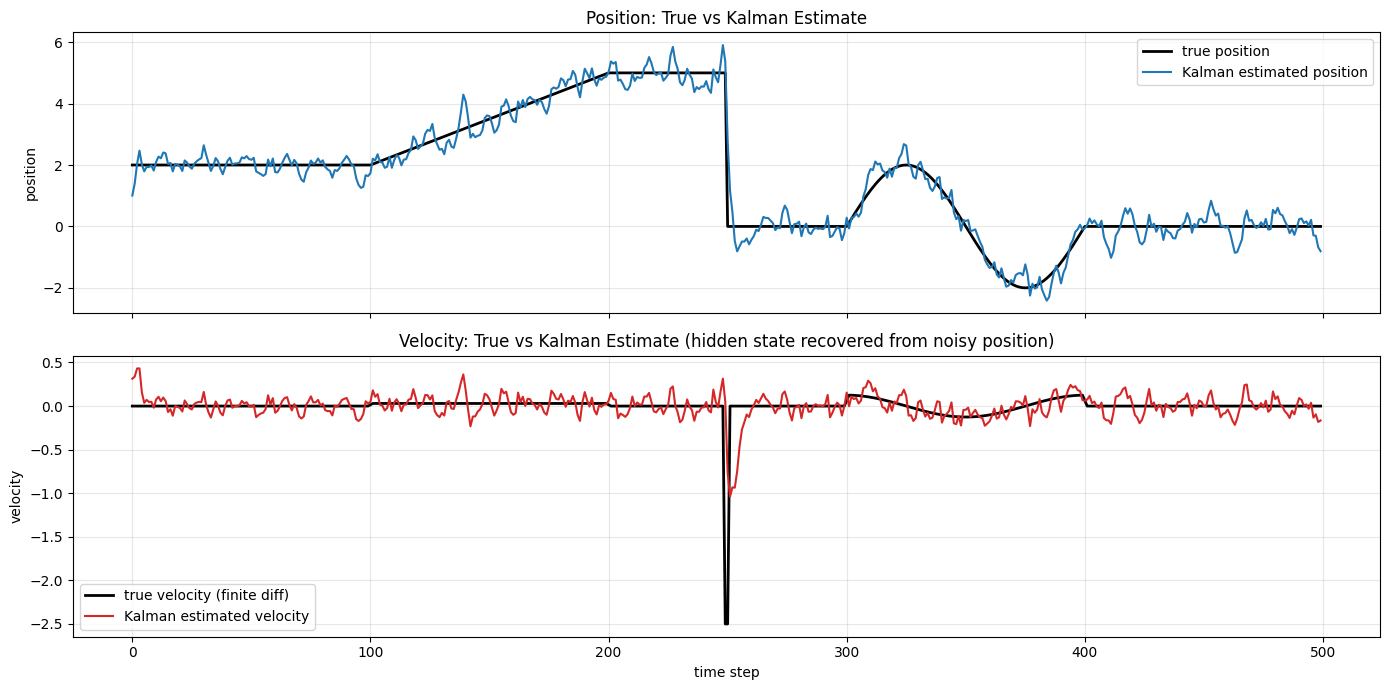

In [8]:
# compute true velocity via finite differences for comparison
true_velocity = numpy.gradient(signal_true, dt)

fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(t, signal_true, "k-", linewidth=2, label="true position")
ax.plot(t, kalman_position, "-", linewidth=1.5, label="Kalman estimated position", color="tab:blue")
ax.set_ylabel("position")
ax.set_title("Position: True vs Kalman Estimate")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(t, true_velocity, "k-", linewidth=2, label="true velocity (finite diff)")
ax.plot(t, kalman_velocity, "-", linewidth=1.5, label="Kalman estimated velocity", color="tab:red")
ax.set_ylabel("velocity")
ax.set_xlabel("time step")
ax.set_title("Velocity: True vs Kalman Estimate (hidden state recovered from noisy position)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Effect of process noise tuning

The process noise covariance $Q$ controls the trade-off:
- **Large Q** → filter trusts measurements more → faster response, less smoothing
- **Small Q** → filter trusts the model more → more smoothing, slower response

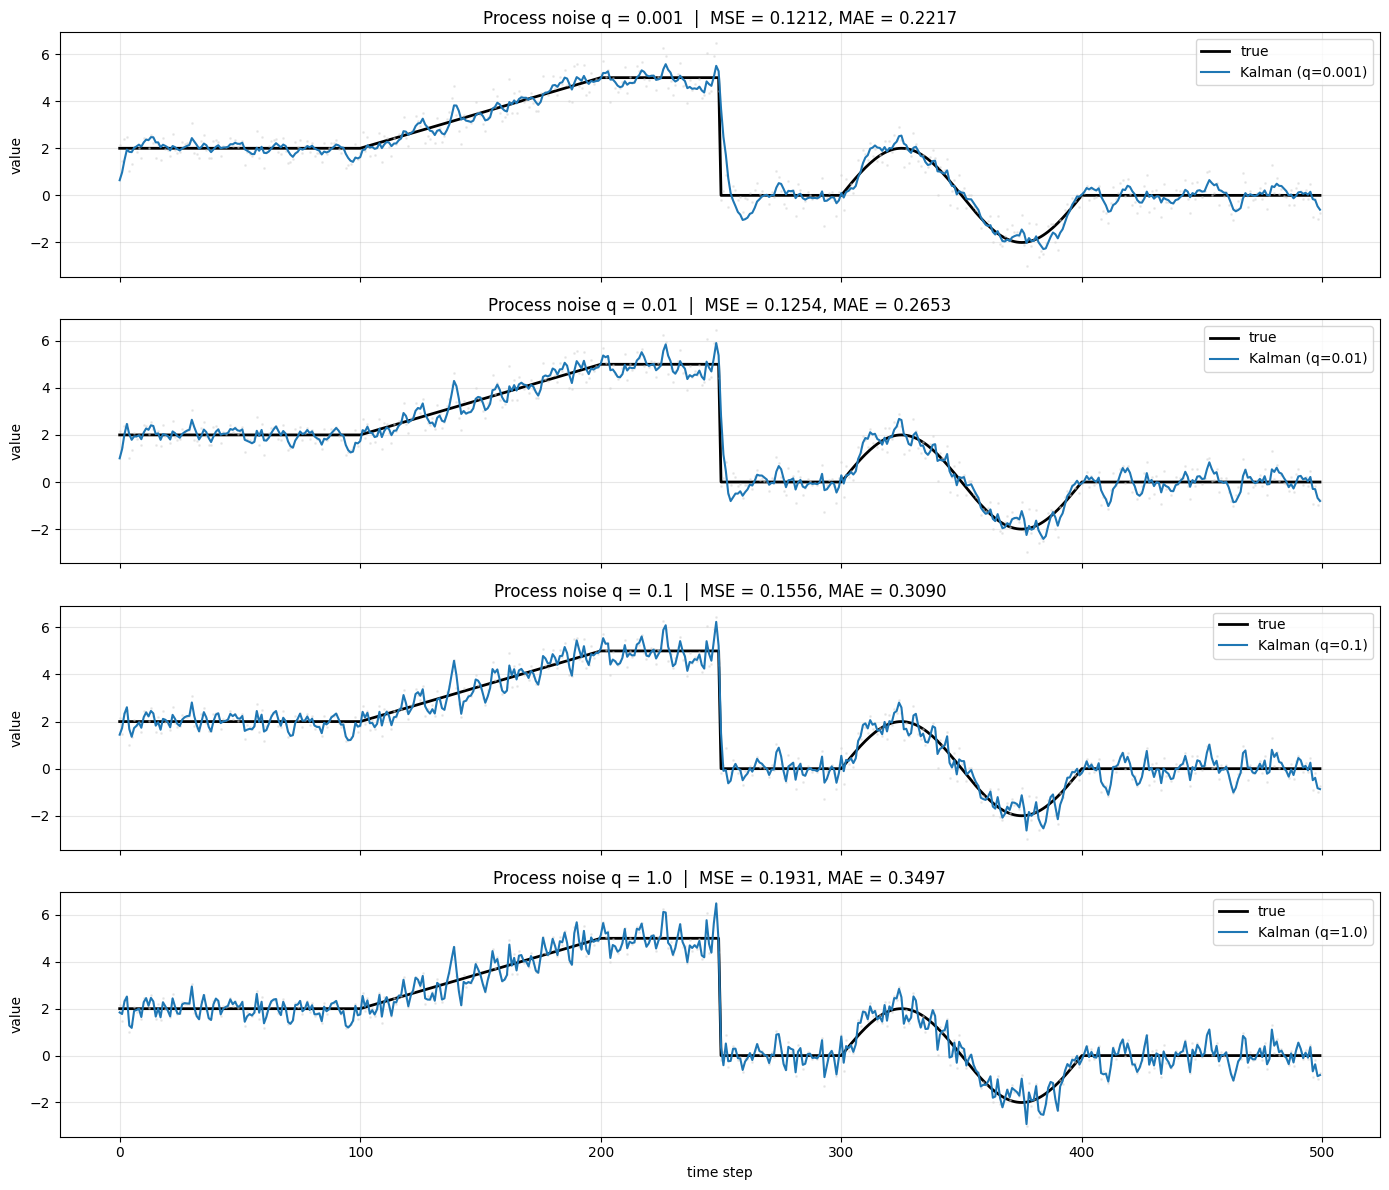

In [9]:
q_values = [0.001, 0.01, 0.1, 1.0]

fig, axes = plt.subplots(len(q_values), 1, figsize=(14, 3 * len(q_values)), sharex=True)

for idx, q_val in enumerate(q_values):
    Q_test = numpy.array([
        [0.25 * dt**4, 0.5 * dt**3],
        [0.5  * dt**3, 1.0 * dt**2]
    ]) * q_val

    kf_test = AILibs.dsp.KalmanFilter(A, B, H, Q_test, R)
    
    positions = numpy.zeros(n_steps)
    for i in range(n_steps):
        y_obs = numpy.array([[signal_noisy[i]]])
        x_est = kf_test.step(y_obs, u_zero)
        positions[i] = x_est[0, 0]

    mse, mae = compute_errors(positions, signal_true)
    
    ax = axes[idx]
    ax.plot(t, signal_true, "k-", linewidth=2, label="true")
    ax.plot(t, signal_noisy, ".", color="lightgray", markersize=2, alpha=0.4)
    ax.plot(t, positions, "-", linewidth=1.5, color="tab:blue", label=f"Kalman (q={q_val})")
    ax.set_ylabel("value")
    ax.set_title(f"Process noise q = {q_val}  |  MSE = {mse:.4f}, MAE = {mae:.4f}")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("time step")
plt.tight_layout()
plt.show()

## Summary

| Property | EMA | Kalman Filter |
|---|---|---|
| **Model** | None (pure smoothing) | Dynamics model (position + velocity) |
| **Tuning** | Single parameter α | Process noise Q, measurement noise R |
| **Response to step** | Exponential lag | Faster — velocity state adapts |
| **Hidden states** | ✗ | ✓ (estimates velocity from position) |
| **Optimal** | No | Yes (for linear Gaussian systems) |